> # MNIST Deep Neural Networks on a GPU with PyTorch

In this time I train the NN on the GPU for predict written numbers from MNIST class from torchvision.datasets. Dataset size is 60000 images, I use 80% for training and 20% for test.



## Preparing the Data

We begin by importing the required modules & classes.

In [ ]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1587428190859/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [4]:
batch_size=128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Can you figure out what the `num_workers` and `pin_memory` are used for? Try looking into the documentation: https://pytorch.org/docs/stable/data.html

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


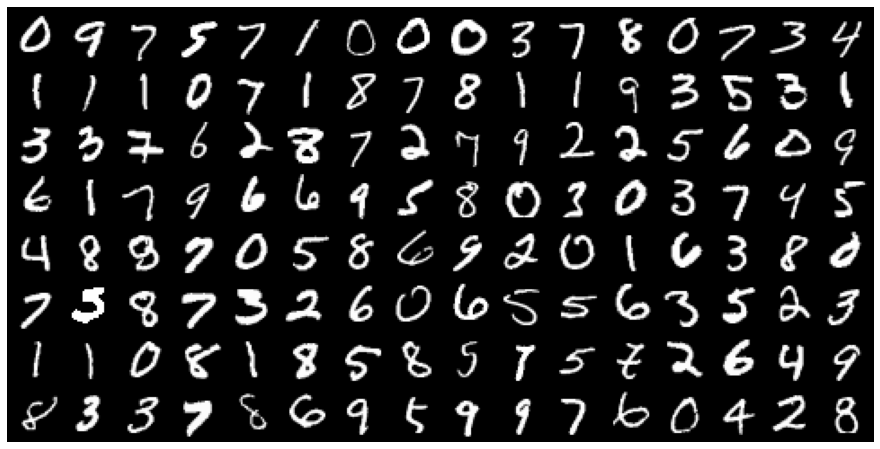

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

To improve upon [logistic regression](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), we'll create a neural network with one **hidden layer**. Here's what this means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We'll create a model that contains a hidden layer with 32 activations.

In [9]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [10]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset, and pass them into our model.

In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3054041862487793
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1173, -0.1632, -0.1573, -0.0141,  0.0975, -0.0864,  0.0244,  0.0096,
         -0.2322, -0.0528],
        [ 0.1039, -0.0438, -0.0666, -0.1732,  0.2203,  0.0270, -0.0801,  0.0133,
         -0.1482, -0.0645]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on [Kaggle kernels](https://www.kaggle.com/kernels) or [Google Colab](https://colab.research.google.com/), or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html) or [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [13]:
torch.cuda.is_available()

False

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cpu')

Next, let's define a function that can move data and model to a chosen device.

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [20]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([3, 4, 4, 7, 7, 0, 2, 4, 8, 8, 0, 1, 7, 1, 3, 5, 1, 8, 1, 5, 7, 7, 8, 1,
        5, 3, 8, 4, 5, 2, 8, 2, 5, 9, 4, 8, 4, 1, 7, 0, 4, 5, 4, 7, 2, 2, 9, 2,
        6, 8, 1, 3, 6, 3, 2, 5, 5, 4, 4, 6, 9, 6, 2, 9, 4, 9, 7, 6, 6, 1, 9, 5,
        2, 6, 7, 4, 0, 8, 8, 1, 9, 3, 3, 1, 9, 2, 2, 1, 1, 7, 5, 3, 3, 2, 7, 6,
        5, 9, 1, 3, 1, 3, 7, 8, 2, 4, 1, 9, 6, 9, 1, 7, 6, 4, 8, 9, 0, 4, 1, 2,
        5, 9, 9, 4, 9, 4, 3, 5, 1, 6, 1, 2, 5, 7, 9, 8, 8, 4, 6, 4, 7, 9, 2, 9,
        9, 8, 8, 7, 5, 6, 3, 7, 3, 1, 2, 1, 9, 6, 6, 6, 6, 7, 3, 6, 5, 2, 9, 3,
        0, 6, 1, 0, 7, 0, 1, 3, 5, 8, 1, 2, 1, 4, 3, 5, 7, 8, 1, 4, 2, 3, 4, 1,
        4, 2, 5, 6, 9, 2, 0, 0, 6, 8, 2, 4, 1, 9, 4, 6, 7, 2, 9, 1, 9, 2, 1, 6,
        9, 2, 0, 2, 9, 6, 6, 3, 2, 4, 6, 1, 0, 0, 0, 0, 5, 0, 2, 9, 0, 7, 3, 3,
        5, 6, 2, 9, 4, 6, 2, 2, 4, 4, 0, 2, 4, 9, 0, 7])


## Training the Model

We can use the exact same training loops from the logistic regression notebook.

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [22]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [24]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.305887222290039, 'val_acc': 0.10791015625}]

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.5.

In [25]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2320, val_acc: 0.9323
Epoch [1], val_loss: 0.1838, val_acc: 0.9457
Epoch [2], val_loss: 0.1847, val_acc: 0.9466
Epoch [3], val_loss: 0.1643, val_acc: 0.9489
Epoch [4], val_loss: 0.1432, val_acc: 0.9583


96% is pretty good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [26]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1279, val_acc: 0.9636
Epoch [1], val_loss: 0.1274, val_acc: 0.9643
Epoch [2], val_loss: 0.1269, val_acc: 0.9658
Epoch [3], val_loss: 0.1264, val_acc: 0.9648
Epoch [4], val_loss: 0.1230, val_acc: 0.9654


We can now plot the losses & accuracies to study how the model improves over time.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

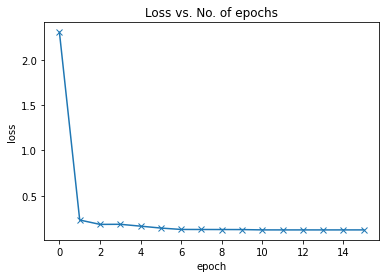

In [29]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

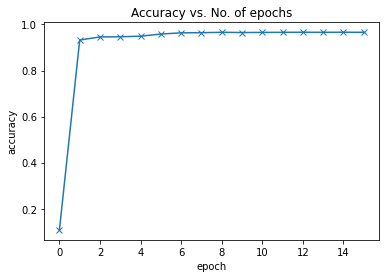

In [30]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only reach around 86% accuracy) by a huge margin! It quickly reaches an accuracy of 97%, but doesn't improve much beyond this. To improve the accuracy further, we need to make the model more powerful. As you can probably guess, this can be achieved by increasing the size of the hidden layer, or adding more hidden layers.